In [25]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

df = pd.read_csv(
    "/Users/nguyennguyen/Desktop/github_repos/personal/rag_medical/src/data/emotion_data/test.csv"
)
texts = df["text"].astype(str).tolist()
labels = df["label"].tolist()


# Tokenize the text data as input for LSTM
def tokenize_texts(texts):
    tokenized_texts = []
    for text in texts:
        tokenized_text = [ord(char) for char in text]
        tokenized_texts.append(tokenized_text)
    return tokenized_texts


tokenized_texts = tokenize_texts(texts)
max_length = max(len(text) for text in tokenized_texts)
# Pad sequences to the same length
for i in range(len(tokenized_texts)):
    tokenized_texts[i] += [0] * (max_length - len(tokenized_texts[i]))
# Convert to tensor
trainX = torch.tensor(tokenized_texts, dtype=torch.float32)
trainX = trainX.view(
    -1, max_length, 1
)  # Reshape to (batch_size, seq_length, input_size)
trainY = torch.tensor(labels, dtype=torch.float32).view(
    -1, 1
)  # Reshape labels to match output shape
# Normalize the data
trainX = (trainX - trainX.mean()) / trainX.std()
trainY = (trainY - trainY.mean()) / trainY.std()
# Split the data into training and testing sets
train_size = int(len(trainX) * 0.8)
test_size = len(trainX) - train_size
trainX, testX = trainX[:train_size], trainX[train_size:]
trainY, testY = trainY[:train_size], trainY[train_size:]

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [27]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
num_epochs = 10
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0 = h0.detach()
    c0 = c0.detach()

    # if (epoch+1) % 10 == 0:
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 1.0105
Epoch [2/10], Loss: 1.0693
Epoch [3/10], Loss: 1.0139
Epoch [4/10], Loss: 1.0130
Epoch [5/10], Loss: 1.0167
Epoch [6/10], Loss: 1.0143
Epoch [7/10], Loss: 1.0116
Epoch [8/10], Loss: 1.0104
Epoch [9/10], Loss: 1.0109
Epoch [10/10], Loss: 1.0117


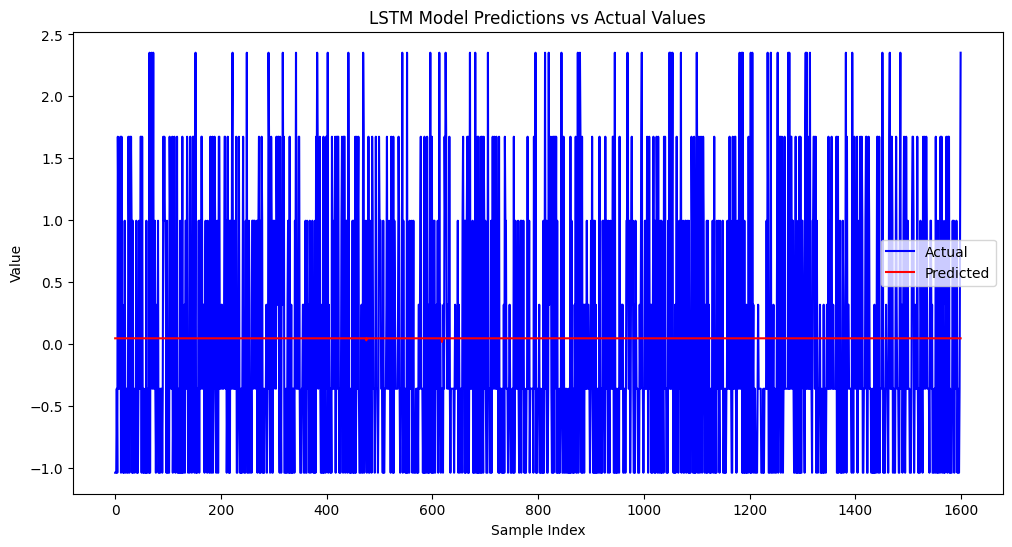

In [29]:
model.eval()
h0, c0 = None, None
predicted, _, _ = model(trainX, h0, c0)
# Plot the results between the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(trainY.numpy(), label="Actual", color="blue")
plt.plot(predicted.detach().numpy(), label="Predicted", color="red")
plt.title("LSTM Model Predictions vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.show()